# Lesson 1 - What's your pet 

### Trying to pass pretrained weights into Learner created model, and making create_cnn working with custom models. I am using resnet50 only to make it comparable to the usual fastai resnet50 training scores to confirm that my method works.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
gpu_device = 1

defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/home/haider/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

[PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/Ragdoll_160.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/havanese_82.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/great_pyrenees_62.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/basset_hound_91.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/Ragdoll_110.jpg')]

In [8]:
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [9]:
bs = 64

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [11]:
import pretrainedmodels

In [12]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [13]:
# this works
def get_model(pretrained=True, model_name = 'resnet50', **kwargs ): 
    if pretrained:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    else:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
    return arch

In [14]:
# get_model()  # uncomment if you want to see its arch

In [15]:
custom_head = create_head(nf=2048*2, nc=37, ps=0.5, bn_final=False) 

In [16]:
# Although that original resnet50 last layer in_features=2048 as you can see below, but the modified fastai head should be in_features = 2048 *2 since it has 2 Pooling
# AdaptiveConcatPool2d((ap): AdaptiveAvgPool2d(output_size=1) + (mp): AdaptiveMaxPool2d(output_size=1)
children(models.resnet50())[-2:]

[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [17]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=37, bias=True)
)

In [18]:
fastai_resnet50=nn.Sequential(*list(children(get_model(model_name = 'resnet50'))[:-2]),custom_head)

In [19]:
learn = Learner(data, fastai_resnet50, metrics=error_rate)  # It seems `Learner' is not using transfer learning. Jeremy: It’s better to use create_cnn, so that fastai will create a version you can use for transfer learning for your problem.
# https://forums.fast.ai/t/lesson-5-advanced-discussion/30865/21

In [20]:
# fastai_resnet50  # uncomment if you want to see its arch

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


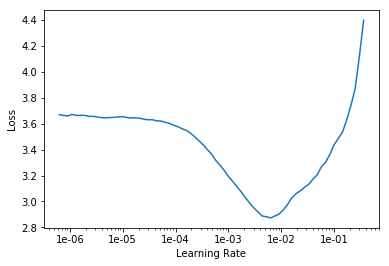

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5) 

epoch,train_loss,valid_loss,error_rate
1,2.253236,9.110213,0.941137
2,2.200139,3.764019,0.828146
3,1.672000,2.002097,0.593369
4,1.105544,0.818362,0.250338
5,0.800097,0.618695,0.207037


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


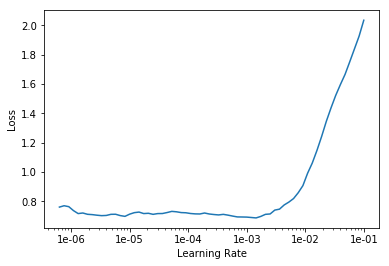

In [24]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [25]:
# learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4)) 

ZeroDivisionError: division by zero

### Comparing the previous learn scores (which seem did not use pretrained weights) with create_cnn method. 

In [26]:
fastai_resnet50=nn.Sequential(*list(children(get_model(model_name = 'resnet50'))[:-2]),custom_head)

In [27]:
def get_fastai_model(pretrained=True, **kwargs ): 
    return fastai_resnet50

In [28]:
# get_fastai_model()  # uncomment if you want to see its arch. You can see that it is identical to model.resnet50

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [29]:
learn = create_cnn(data, get_fastai_model, metrics=error_rate)

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


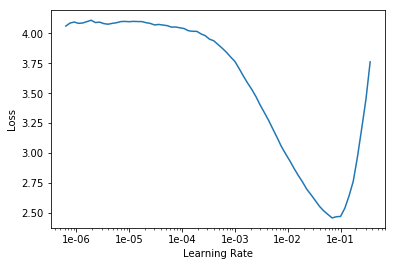

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5) 

epoch,train_loss,valid_loss,error_rate
1,0.623604,0.272269,0.094046
2,0.360016,0.214112,0.077131
3,0.294362,0.167646,0.060217
4,0.185019,0.154593,0.052774
5,0.125409,0.139804,0.045332


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


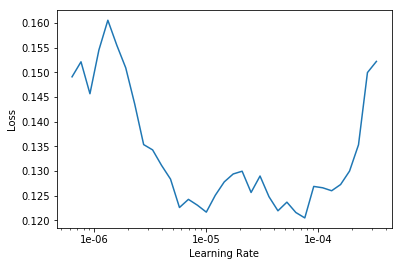

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
# learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate
1,0.124935,0.139686,0.046685


### Comparing the previous learn scores with the original fastai create_cnn method. 

In [35]:
learn = create_cnn(data,models.resnet50, metrics=error_rate)

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


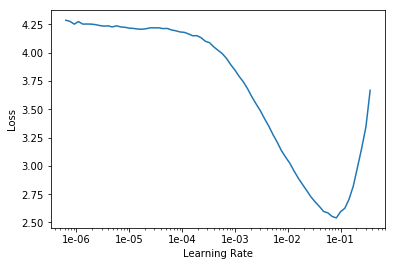

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5) 

epoch,train_loss,valid_loss,error_rate
1,0.653340,0.251246,0.087957
2,0.369305,0.202131,0.068336
3,0.280412,0.178356,0.057510
4,0.194673,0.140904,0.049391
5,0.142086,0.135555,0.048714


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


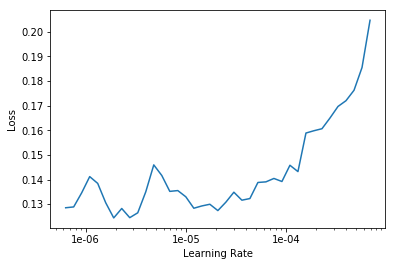

In [39]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [40]:
# learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate
1,0.134266,0.129403,0.044655
